# Import packages

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
import ROOT
import pandas as pd
from root_pandas import read_root
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
from iminuit import Minuit, describe, Struct

# Defines how to get dataframe from ROOT TTree

In [21]:
def getData(inputFiles):
    
    cols = []
    cols.append('cluster_pt')
    cols.append('cluster_eta')
    cols.append('cluster_phi')
    cols.append('cluster_e_cross')
    cols.append('cluster_e')
    cols.append('cluster_ncell')
    cols.append('cluster_NN1')
    cols.append('cluster_NN2')
    cols.append('cluster_Lambda')
    
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print 'Processed', inputFilename, 'in',  end-start, 'seconds'
    return pd.concat([x for x in dataframes])

# Gets dataframes from dataset(s)

In [22]:
# NTuples found in /project/projectdirs/alice/NTuples
mcFiles = ["16c3b_small.root"]#["16c3b_small.root"]
dataFiles = ["13d_small.root"]#,"13e_small.root",'13e_small.root']
mcHists = getData(mcFiles)
dataHists = getData(dataFiles)

Processed 16c3b_small.root in 8.56899404526 seconds
Processed 13d_small.root in 16.1363408566 seconds


# Define cuts

In [23]:
def applyCut(inputDataframe, cut, text=None):
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0]
    return cutDataframe

In [26]:
def applyCuts(fullDataframe):  
    fullDataframe.eval('cluster_ecross_over_e = cluster_e_cross/cluster_e', inplace=True)
    
    dataframe = fullDataframe
    dataframe = applyCut(dataframe, 'cluster_pt>8.0', 'pt > 8 GeV:')
    dataframe = applyCut(dataframe, 'cluster_ecross_over_e>0.05', 'ecross/e > 0.05:')
    dataframe = applyCut(dataframe, 'cluster_NN1>0 and cluster_NN1<1.0')
    dataframe = applyCut(dataframe, 'cluster_NN2>0 and cluster_NN2<1.0', 'NN1 and NN2 between 0 and 1:')
    dataframe = applyCut(dataframe, 'cluster_ncell>2', 'ncell > 2:')
    dataframe = applyCut(dataframe, 'cluster_Lambda<2.0', 'lambda < 2.0:')
    return dataframe

# Apply cuts

In [27]:
dataHists = applyCuts(dataHists)
mcHists = applyCuts(mcHists)

pt > 8 GeV: 326202
ecross/e > 0.05: 255603
NN1 and NN2 between 0 and 1: 243129
ncell > 2: 242976
lambda < 2.0: 242613
pt > 8 GeV: 275653
ecross/e > 0.05: 269121
NN1 and NN2 between 0 and 1: 268465
ncell > 2: 268163
lambda < 2.0: 268028


# Define plotting 

In [36]:
def plotcorr(histo,label,figname,nbins=100):
    x = histo['cluster_NN2']
    y = histo['cluster_Lambda']
    nullfmt = NullFormatter()         # no labels
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.04
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    fig = plt.figure(1, figsize=(8, 8))
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    axHistx.xaxis.set_major_formatter(nullfmt) #no labels
    axHisty.yaxis.set_major_formatter(nullfmt)
    hb = axScatter.hexbin(x, y, cmap='viridis') #gridsize=60
    axScatter.plot((0, 1), (0.27, 0.27), 'r-',linestyle=':')
    axScatter.plot((0.85, 0.85), (0, 1.0), 'r-',linestyle=':')
    plt.text(0.22, 0.90,label, horizontalalignment='center',  verticalalignment='center', transform=axScatter.transAxes, bbox=dict(facecolor='white', alpha=0.75))
    binwidth = 0.25
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    axScatter.set_xlim((0.0, 1.0))
    axScatter.set_ylim((0.0, 1.0))
    axScatter.set_xlabel('NN output')
    axScatter.set_ylabel('Lambda')
    yhist, xhist, patches = axHistx.hist(x,nbins, range=(0, 1.0)) #here it gets the NN histogram
    xhist= np.delete(xhist,-1)
    xhist = np.add( xhist, (xhist[1]-xhist[0])/2.0 )
    yerrhist = np.sqrt(yhist)
    xerrhist = np.full(len(yerrhist), (xhist[1]-xhist[0])/2.0)
    axHisty.hist(y,nbins, range=(0.0,1.0), orientation='horizontal')
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    plt.show()
    fig.savefig('../JupyterPNGOutput/'+figname+'.png', dpi=fig.dpi)
    return yhist, xhist, yerrhist, xerrhist
    

# Function to cut pt ranges

In [29]:
def cutptrange(data, ptmin, ptmax):
    datacut = data
    datacut = full.query('cluster_pt>%f and cluster_pt<%f' %(ptmin,ptmax))
    return datacut

# Define pt bins and plot

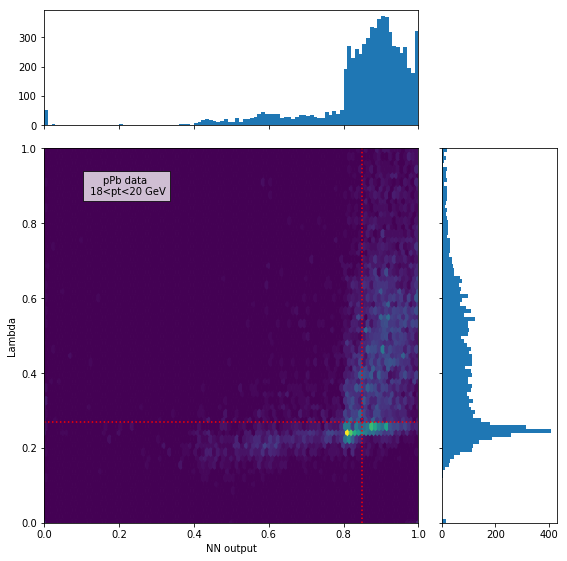

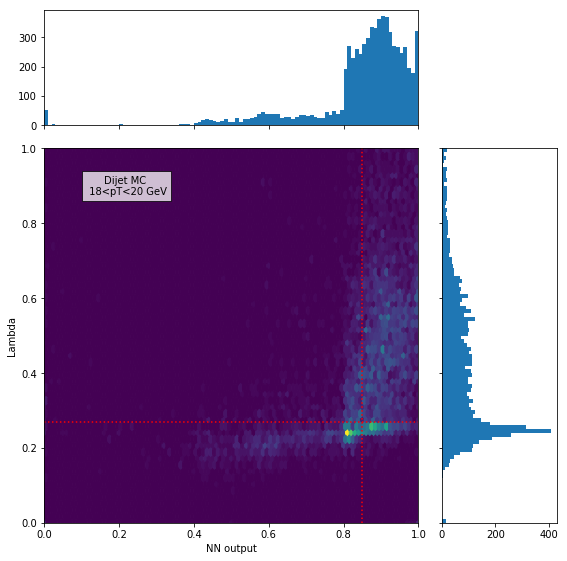

In [37]:
binedges = [18.0, 20.0]

for ipt in range(len(binedges)-1):
    ptmin = binedges[ipt]
    ptmax = binedges[ipt+1]
    hist= cutptrange(dataHists, ptmin, ptmax)
    plotcorr(hist,'pPb data \n %2.0f<pt<%2.0f GeV' %(ptmin,ptmax),'all_Data%2.0f_%2.0f' %(ptmin,ptmax))
    ##dealing with MC
    histMC = cutptrange(mcHists, ptmin, ptmax)
    plotcorr(histMC,'Dijet MC \n %2.0f<pT<%2.0f GeV' %(ptmin,ptmax),'all_MC_%2.0f_%2.0f' %(ptmin,ptmax))
    
    
    